In [1]:
from transformers import pipeline
from PIL import ImageDraw
from PIL import Image
import numpy as np

import skimage

/Users/thivyeshahilathasan/Library/Caches/pypoetry/virtualenvs/cv-tutorial-cap-aU5aeIk7-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Initialize detection pipeline
checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

In [3]:
image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

In [4]:
predictions = detector(
    image,
    candidate_labels=["face", "rocket", "nasa badge", "star-spangled banner"]
)

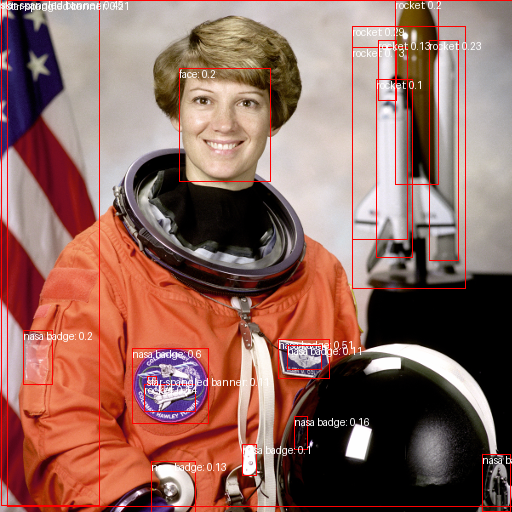

In [5]:
draw = ImageDraw.Draw(image)
for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white")

display(image)

In [6]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

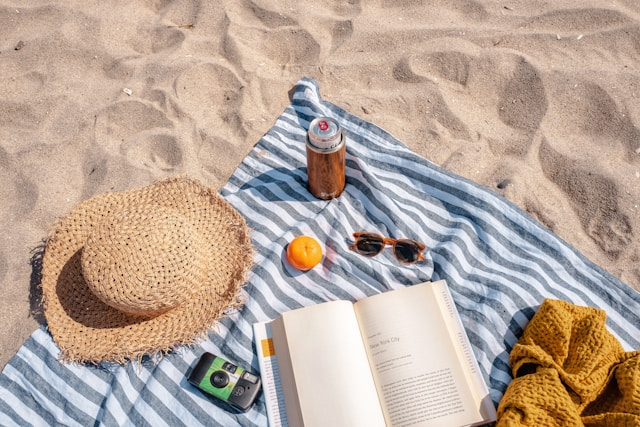

In [7]:
import requests

url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
im = Image.open(requests.get(url, stream=True).raw)
display(im)

In [8]:
text_queries = ["hat", "book", "sunglasses", "camera"]
inputs = processor(text=text_queries, images=im, return_tensors="pt")

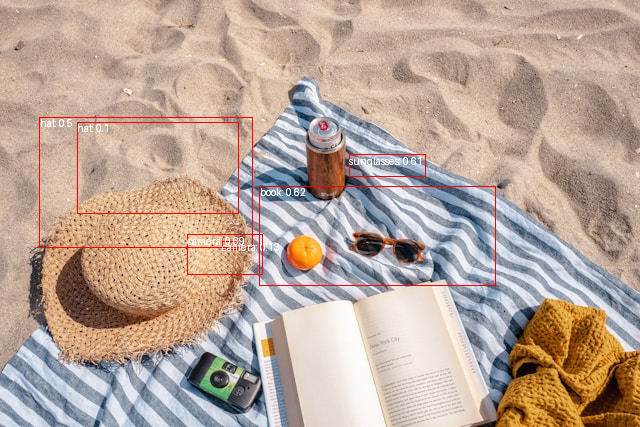

In [10]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="white")

im

In [11]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_target = Image.open(requests.get(url, stream=True).raw)

query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

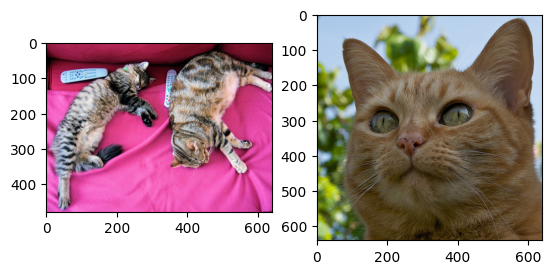

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)

In [13]:
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")

In [19]:
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image_target)

scores = results["scores"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)

plt.imshow(image_target)

TypeError: object of type 'NoneType' has no len()